## Simulated navigation trajectories

This notebook can be used to generate simulated trajectories based on three different approaches reported in the paper:
1. [Random walk](#random_walk)
2. [Proportional connectivity bias](#prop_bias)
3. [Consistent connectivity bias](#strong_bias)

The code was identical for the two experiments but the human data we read in was different (as participants covered larger distances in Exp 2). In this notebook, we only include the data for Exp 2, but we provide the simulated trajectories for Exp 1 in the 'summary' folder as well. 

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import random
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt
from math import hypot
from math import sqrt

In [17]:
### Human data ###
# read in summary data
# filter out only timepoints where participants moved
# calculate overall average
# store starting coordinates

## filter out timepoints when participants moved while ON PATH
data_raw = pd.read_csv("human_vals/exp2_diff_sq_timepoints_lag1.csv", sep=",")
data_raw['root'] = np.sqrt(np.asarray(data_raw['diff_sq']))

data_mov = data_raw[data_raw['diff_sq'] > 0]
## calculate average number of movement timepoints on path across participants
data_len = data_mov.groupby('sub')['sub'].count()
data_dist_mean = data_mov.groupby('sub')['root'].sum()
mean_num_steps = np.mean(data_len)
mean_dist = np.mean(data_dist_mean)
sd_dist = np.std(data_dist_mean)
print(f"mean distance: {mean_dist}")

## calculate mean and SD of step distances
mean_step_dist = np.mean(data_mov.root)
sd_step_dist = np.std(data_mov.root)
# maximum to compare with random distribution
max_step_dist = np.max(data_mov.diff_sq)

## get start location (can just read in one subject)
# everyone started in the same place
frame = pd.read_csv("human_vals/0015.txt", sep=";", names=['x', 'y', 'z', 'heading'], header=None)

start_x_1 = frame['x'].iloc[0]
start_y_1 = frame['z'].iloc[0]

start_x = -1*start_x_1 + 738
start_y = -1*start_y_1 + 510

print(f"start x: {start_x}, start y: {start_y}")

mean distance: 3817.766674503047
start x: 775.4, start y: 583.8


Okay, now we have the human time/distance benchmarks that we want to match.

### Logic of analysis:
At each decision point, select an option (random for random walk, weighted for biased walks). Extract axial integration value for selected segment, repeat it until distance to next decision point is reached (the resulting data format is similar to human participants). <br>

In [10]:
# plot axial integration values
im = plt.imread("Full_Info_Silcton_map.png")

map_file = pd.read_csv("VGA_integration_populated.txt", sep="\t")
# rescale to match navigation coordinates
map_file['x_scaled'] = map_file.x*1.87 + 360
map_file['y_scaled'] = map_file.y*1.87 + 540

#plt.savefig('integration_map.png',bbox_inches='tight')

In [18]:
dp_list = genfromtxt('graph_based_sim_nav.csv', delimiter=',')
dp_list_coord =  dp_list[:,3:5]

# split into x and y columns
dp_list_coord_x = dp_list_coord[:,0]
dp_list_coord_y = dp_list_coord[:,1]

# for consistency, we should use raw coordinates & then transform for plotting only.
# the coordinates were initially determined by plotting them on the map so we transform them here

dp_list_coord_x =  (dp_list_coord_x - 738)*(-1)
dp_list_coord_y =  (dp_list_coord_y - 510)*(-1)

#print(dp_list_coord_x)
#print(dp_list_coord_y)

### 1. Random walk with no backtracking  <a name="random_walk"></a>

In [19]:
#### loop to build step-by-step graph exploration structure

dp_list = genfromtxt('graph_based_sim_nav.csv', delimiter=',')
dp_list_coord =  dp_list[:,3:5]

# split into x and y columns
dp_list_coord_x = dp_list_coord[:,0]
dp_list_coord_y = dp_list_coord[:,1]

# for consistency, we should use raw coordinates & then transform for plotting only.
# the coordinates were initially determined by plotting them on the map
# raw coordinates are now saved in csv file that we read in - don't uncomment the lines below.

#dp_list_coord_x =  (dp_list_coord_x - 738)*(-1)
#print(dp_list_coord_test_x[0])
#print(dp_list_coord_x[0])
#dp_list_coord_y =  (dp_list_coord_y - 510)*(-1)
#print(dp_list_coord_test_y[0])

# save decision point IDs
dp_id_list = dp_list[:,0]
dp_id_list = dp_id_list.tolist()

# initialize simulation lists to append to
trajectory_list = list()
integration_list = list()
distance_list = list()

for sim in range(100):
    # initialize lists to append to
    dp_id = [0 for i in range(1)]
    dp_id[0] = 1

    dp_loc = list()
    dist_list = list()
    integ_list = list()

    # initialize cumulative distance
    cumulative_dist = 0
    
    # generate a random value where to stop appending (= allowance for this 'participant')
    # range is between mean-sd and mean+sd
    allowance = round(random.uniform(mean_dist-(2*sd_dist), mean_dist+(1.5*sd_dist)), 1)

    for i in range(1000):
        cur_dp = dp_id[i] # start at the same start location for everyone!
        #print('current dp', cur_dp)
        cur_index = dp_id_list.index(cur_dp)
        #print(cur_index)
        num_options = int(dp_list[cur_index,2])
        #print(num_options)
        selected_option = random.choice(range(1,num_options+1))
        #print('selected option', selected_option)

        next_segment = dp_list[cur_index,4+selected_option]
        #print('next segment', next_segment)

        ### comment this out if you want a FULLY random walk WITH backtracking
        ### this prevents backtracking:
        while next_segment == dp_id[i-1]:
            # if the currently selected option is the same as the segment we just came from
            # select a different one & repeat the process until a different one is chosen
            #print('repeated segment')
            if cur_dp == 24:
                # this is the one time we allow backtracking because there's only one connected node
                break
            else:
                selected_option = random.choice(range(1,num_options+1))
                #print('selected option', selected_option)
                next_segment = dp_list[cur_index,4+selected_option]
                if next_segment != dp_id[i-1]:
                    # once the selected segment is different, break the while loop
                    break

        next_index = dp_id_list.index(next_segment)
        #print('next index', next_index)
        cur_loc = dp_list_coord[cur_index]
        dp_loc.append(cur_loc)
        #print(cur_loc)
        next_loc = dp_list_coord[next_index]
        #print(next_loc)
        # append integration value
        cur_integ = dp_list[cur_index,4+num_options+selected_option]
        #print('integration value', cur_integ)
        integ_list.append(cur_integ)
        # calculate distance
        dist = hypot(dp_list_coord_x[next_index] - dp_list_coord_x[cur_index], dp_list_coord_y[next_index] - dp_list_coord_y[cur_index])
        dist_list.append(dist)
        dp_id.append(next_segment)
        cumulative_dist = cumulative_dist + dist
        #print(cumulative_dist)
        if cumulative_dist > allowance:
            break
    trajectory_list.append(dp_loc)
    integration_list.append(integ_list)
    distance_list.append(dist_list)

#### Fully random walk

In [20]:
# FULL RANDOM WALK
#### loop to build step-by-step graph exploration structure

dp_list = genfromtxt('graph_based_sim_nav.csv', delimiter=',')
dp_list_coord =  dp_list[:,3:5]

# split into x and y columns
dp_list_coord_x = dp_list_coord[:,0]
dp_list_coord_y = dp_list_coord[:,1]

# for consistency, we should use raw coordinates & then transform for plotting only.
# the coordinates were initially determined by plotting them on the map
# raw coordinates are now saved in csv file that we read in - don't uncomment the lines below.

#dp_list_coord_x =  (dp_list_coord_x - 738)*(-1)
#print(dp_list_coord_test_x[0])
#print(dp_list_coord_x[0])
#dp_list_coord_y =  (dp_list_coord_y - 510)*(-1)
#print(dp_list_coord_test_y[0])

# save decision point IDs
dp_id_list = dp_list[:,0]
dp_id_list = dp_id_list.tolist()

# initialize simulation lists to append to
trajectory_list = list()
integration_list = list()
distance_list = list()

for sim in range(1000):
    # initialize lists to append to
    dp_id = [0 for i in range(1)]
    dp_id[0] = 1

    dp_loc = list()
    dist_list = list()
    integ_list = list()

    # initialize cumulative distance
    cumulative_dist = 0
    
    # generate a random value where to stop appending (= allowance for this 'participant')
    # range is between mean-sd and mean+sd
    allowance = round(random.uniform(mean_dist-(2*sd_dist), mean_dist+(1.5*sd_dist)), 1)

    for i in range(1000):
        cur_dp = dp_id[i] # start at the same start location for everyone!
        #print('current dp', cur_dp)
        cur_index = dp_id_list.index(cur_dp)
        #print(cur_index)
        num_options = int(dp_list[cur_index,2])
        #print(num_options)
        selected_option = random.choice(range(1,num_options+1))
        #print('selected option', selected_option)

        next_segment = dp_list[cur_index,4+selected_option]
        #print('next segment', next_segment)

        ### comment this out if you want a FULLY random walk WITH backtracking
        ### this prevents backtracking:
        #while next_segment == dp_id[i-1]:
            # if the currently selected option is the same as the segment we just came from
            # select a different one & repeat the process until a different one is chosen
            #print('repeated segment')
        #    if cur_dp == 24:
                # this is the one time we allow backtracking because there's only one connected node
        #        break
        #    else:
        #        selected_option = random.choice(range(1,num_options+1))
                #print('selected option', selected_option)
        #        next_segment = dp_list[cur_index,4+selected_option]
        #        if next_segment != dp_id[i-1]:
                    # once the selected segment is different, break the while loop
        #            break

        next_index = dp_id_list.index(next_segment)
        #print('next index', next_index)
        cur_loc = dp_list_coord[cur_index]
        dp_loc.append(cur_loc)
        #print(cur_loc)
        next_loc = dp_list_coord[next_index]
        #print(next_loc)
        # append integration value
        cur_integ = dp_list[cur_index,4+num_options+selected_option]
        #print('integration value', cur_integ)
        integ_list.append(cur_integ)
        # calculate distance
        dist = hypot(dp_list_coord_x[next_index] - dp_list_coord_x[cur_index], dp_list_coord_y[next_index] - dp_list_coord_y[cur_index])
        dist_list.append(dist)
        dp_id.append(next_segment)
        cumulative_dist = cumulative_dist + dist
        #print(cumulative_dist)
        if cumulative_dist > allowance:
            break
    trajectory_list.append(dp_loc)
    integration_list.append(integ_list)
    distance_list.append(dist_list)

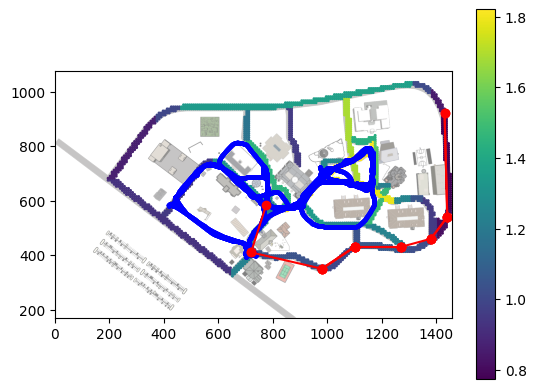

In [13]:
### Visually examine the trajectories ###
## define functions to extract x and y coordinates
## and to transform them for plotting

def Extract_x(lst):
    return [item[0] for item in lst]

def Extract_y(lst):
    return [item[1] for item in lst]

def x_transform(x):
    return(-x + 738)

def y_transform(y):
    return(-y + 510)

# look at random trajectories by changing the number in brackets
dp_loc_arr = np.asarray(trajectory_list[5]) 

x_list = Extract_x(dp_loc_arr)
y_list = Extract_y(dp_loc_arr)

x_list = list(map(x_transform, x_list))
y_list = list(map(y_transform, y_list))

implot = plt.imshow(im,extent=[0,1456,170,1032],alpha=.5)
h = plt.scatter(map_file.x_scaled, map_file.y_scaled, c = map_file['integ'], marker = ".", s= 5, cmap="viridis")

plt.scatter(x_list, y_list, s=20, c='black')

for i in range(0, len(x_list), 1):
    plt.plot(x_list[i:i+2], y_list[i:i+2], 'ro-')
    
# we only have one human nav log here as an example
frame = pd.read_csv("human_vals/0015.txt", sep=";", names=['x', 'y', 'z', 'heading'], header=None)

frame_x = frame['x']
frame_z = frame['z']
frame_x = -1*frame_x + 738
frame_z = -1*frame_z + 510

plt.scatter(frame_x, frame_z, s=3, c='blue')

plt.colorbar(h)
plt.show()

#### Calculate average experienced integration per simulated agent

In [21]:
# initialize empty list for mean integration values
mean_integ_list = list()
timesteps_total_list = list()
dist_total_list = list()

for i in range(len(trajectory_list)): #loop over simulated agents
    cur_agent_dist = distance_list[i]
    cur_agent_integ = integration_list[i]
    dist_total = 0
    timesteps_total = 0
    integ_total = 0
    # loop over distance measures & apply corresponding integration values
    for j in range(len(cur_agent_dist)):
        #print(cur_agent_dist[j])
        #print(cur_agent_integ[j])
        cur_integ = cur_agent_integ[j]
        cur_dist = cur_agent_dist[j]
        timesteps = cur_dist/mean_step_dist
        #print(timesteps)
        integ_timeweighted = round(timesteps,0) * cur_integ
        #print(round(timesteps,0))
        #print(integ_timeweighted)
        integ_total = integ_total + integ_timeweighted
        timesteps_total = timesteps_total + round(timesteps,0)
        dist_total = dist_total + cur_dist
    dist_total_list.append(dist_total)
    timesteps_total_list.append(timesteps_total)
    mean_integ_overall = integ_total/timesteps_total
    mean_integ_list.append(mean_integ_overall)

mean_integ_list = pd.DataFrame(mean_integ_list)
dist_total_list = pd.DataFrame(dist_total_list)
timesteps_total_list = pd.DataFrame(timesteps_total_list)

mean_integ_list.to_csv("exp2_simulated_agent_integration_values_FullRandom.csv",index=False)
# only if you need to check these
#dist_total_list.to_csv("exp2_simulated_agent_distance_values.csv",index=False)
#timesteps_total_list.to_csv("exp2_simulated_agent_timestep_values.csv",index=False)

### 2. Proportional bias towards more highly connected decision points  <a name="prop_bias"></a>

In [ ]:
#### loop to build step-by-step graph exploration structure
dp_list = genfromtxt('graph_based_sim_nav.csv', delimiter=',')
dp_list_coord =  dp_list[:,3:5]

# split into x and y columns
dp_list_coord_x = dp_list_coord[:,0]
dp_list_coord_y = dp_list_coord[:,1]

# for consistency, we should use raw coordinates & then transform for plotting only.
# the coordinates were initially determined by plotting them on the map
# raw coordinates are now saved in csv file that we read in - don't uncomment the lines below.

#dp_list_coord_x =  (dp_list_coord_x - 738)*(-1)
#print(dp_list_coord_test_x[0])
#print(dp_list_coord_x[0])
#dp_list_coord_y =  (dp_list_coord_y - 510)*(-1)
#print(dp_list_coord_test_y[0])

# save decision point IDs
dp_id_list = dp_list[:,0]
dp_id_list = dp_id_list.tolist()

# initialize simulation lists to append to

trajectory_list = list()
integration_list = list()
distance_list = list()
dp_trajectory_list = list()

for sim in range(100):
    
    # initialize lists to append to
    dp_id = [0 for i in range(1)]
    dp_id[0] = 1

    dp_loc = list()
    dist_list = list()
    integ_list = list()

    # initialize cumulative distance
    cumulative_dist = 0
    
    # generate a random value where to stop appending
    # range is between mean-sd and mean+sd
    allowance = round(random.uniform(mean_dist-(2*sd_dist), mean_dist+(1.5*sd_dist)), 1)

    for i in range(1000):
        cur_dp = dp_id[i] # start at the same start location for everyone!
        #print('current dp', cur_dp)
        cur_index = dp_id_list.index(cur_dp)
        #print('current index', cur_index)
        num_options = int(dp_list[cur_index,2])
        #print('number of options at this dp', num_options)
        # this is terribly written.
        # there has to be a better way, but this does the following:
        # sample from the selected columns (5:5+num_options)
        # save as integer values, not floats
        # subtract one to correctly index (0-indexed)
        # save as list, not array
        pos_selections = list(dp_list[cur_index, 5:5+num_options].astype(int) - 1)
        #print('possible selections at this dp', pos_selections)
        weights_at_dp = list(dp_list[pos_selections][:,2].astype(int))
        #print('weights of options at this dp', weights_at_dp)

        weighted_selection = random.choices(pos_selections, weights=weights_at_dp, k=1)[0]
        #print('weighted selection', weighted_selection)

        next_segment = dp_list[weighted_selection,0]
        #print('next segment', next_segment)
        
        ### COMMENT THIS OUT IF YOU WANT A FULLY RANDOM WALK
        ### this prevents backtracking:
        while next_segment == dp_id[i-1]:
            # if the currently selected option is the same as the segment we just came from
            # select a different one & repeat the process until a different one is chosen
            #print('repeated segment')
            if cur_dp == 24:
                # this is the one time we allow backtracking because there's only one connected node
                break
            else:
                weighted_selection = random.choices(pos_selections, weights=weights_at_dp, k=1)[0]
                #print('weighted selection', weighted_selection)

                next_segment = dp_list[weighted_selection,0]
                #print('next segment', next_segment)
                
                if next_segment != dp_id[i-1]:
                    # once the selected segment is different, break the while loop
                    break

        next_index = dp_id_list.index(next_segment)
        #print('next index', next_index)
        cur_loc = dp_list_coord[cur_index]
        dp_loc.append(cur_loc)
        #print(cur_loc)
        next_loc = dp_list_coord[next_index]
        #print(next_loc)
        # append integration value
        cur_integ = dp_list[cur_index,1]
        #print('integration value', cur_integ)
        integ_list.append(cur_integ)
        # calculate distance
        dist = hypot(dp_list_coord_x[next_index] - dp_list_coord_x[cur_index], dp_list_coord_y[next_index] - dp_list_coord_y[cur_index])
        dist_list.append(dist)
        dp_id.append(next_segment)
        cumulative_dist = cumulative_dist + dist
        #print(cumulative_dist)
        if cumulative_dist > allowance:
            break
    trajectory_list.append(dp_loc)
    integration_list.append(integ_list)
    distance_list.append(dist_list)
    dp_trajectory_list.append(dp_id)

#print(integration_list[99])
#print(dp_trajectory_list[99])

#### Calculate average experienced integration per simulated agent

In [ ]:
# initialize empty list for mean integration values
mean_integ_list = list()
timesteps_total_list = list()
dist_total_list = list()

for i in range(len(trajectory_list)): #loop over simulated agents
    cur_agent_dist = distance_list[i]
    cur_agent_integ = integration_list[i]
    dist_total = 0
    timesteps_total = 0
    integ_total = 0
    # loop over distance measures & apply corresponding integration values
    for j in range(len(cur_agent_dist)):
        #print(cur_agent_dist[j])
        #print(cur_agent_integ[j])
        cur_integ = cur_agent_integ[j]
        cur_dist = cur_agent_dist[j]
        timesteps = cur_dist/mean_step_dist
        #print(timesteps)
        integ_timeweighted = round(timesteps,0) * cur_integ
        #print(round(timesteps,0))
        #print(integ_timeweighted)
        integ_total = integ_total + integ_timeweighted
        timesteps_total = timesteps_total + round(timesteps,0)
        dist_total = dist_total + cur_dist
    dist_total_list.append(dist_total)
    timesteps_total_list.append(timesteps_total)
    mean_integ_overall = integ_total/timesteps_total
    mean_integ_list.append(mean_integ_overall)

mean_integ_list = pd.DataFrame(mean_integ_list)
dist_total_list = pd.DataFrame(dist_total_list)
timesteps_total_list = pd.DataFrame(timesteps_total_list)

mean_integ_list.to_csv("exp2_simulated_agent_integration_values_weighted.csv",index=False)
# only if you need to check these
#dist_total_list.to_csv("exp2_simulated_agent_distance_values_weighted.csv",index=False)
#timesteps_total_list.to_csv("exp2_simulated_agent_timestep_values_weighted.csv",index=False)

### 3. Proportional bias <i> heavily </i> weighted towards more connected options <a name="strong_bias"></a>

In [ ]:
#### loop to build step-by-step graph exploration structure
dp_list = genfromtxt('graph_based_sim_nav.csv', delimiter=',')
dp_list_coord =  dp_list[:,3:5]

# split into x and y columns
dp_list_coord_x = dp_list_coord[:,0]
dp_list_coord_y = dp_list_coord[:,1]

# for consistency, we should use raw coordinates & then transform for plotting only.
# the coordinates were initially determined by plotting them on the map
# raw coordinates are now saved in csv file that we read in - don't uncomment the lines below.

#dp_list_coord_x =  (dp_list_coord_x - 738)*(-1)
#print(dp_list_coord_test_x[0])
#print(dp_list_coord_x[0])
#dp_list_coord_y =  (dp_list_coord_y - 510)*(-1)
#print(dp_list_coord_test_y[0])

# save decision point IDs
dp_id_list = dp_list[:,0]
dp_id_list = dp_id_list.tolist()

# initialize simulation lists to append to

trajectory_list = list()
integration_list = list()
distance_list = list()
dp_trajectory_list = list()

for sim in range(100):
    
    # initialize lists to append to
    dp_id = [0 for i in range(1)]
    dp_id[0] = 1

    dp_loc = list()
    dist_list = list()
    integ_list = list()

    # initialize cumulative distance
    cumulative_dist = 0
    
    # generate a random value where to stop appending
    # range is between mean-sd and mean+sd
    allowance = round(random.uniform(mean_dist-(2*sd_dist), mean_dist+(1.5*sd_dist)), 1)

    for i in range(1000):
        cur_dp = dp_id[i] # start at the same start location for everyone!
        #print('current dp', cur_dp)
        cur_index = dp_id_list.index(cur_dp)
        #print('current index', cur_index)
        num_options = int(dp_list[cur_index,2])
        #print('number of options at this dp', num_options)
        # this is terribly written.
        # there has to be a better way, but this does the following:
        # sample from the selected columns (5:5+num_options)
        # save as integer values, not floats
        # subtract one to correctly index (0-indexed)
        # save as list, not array
        pos_selections = list(dp_list[cur_index, 5:5+num_options].astype(int) - 1)
        #print('possible selections at this dp', pos_selections)
        weights_at_dp = list(dp_list[pos_selections][:,2].astype(int))
        #print('weights of options at this dp', weights_at_dp)
        
        # find options with the highest weights
        indices_max = [index for index, val in enumerate(weights_at_dp) if val == max(weights_at_dp)]
        
        # now increase the weighting of the maximum option by x-fold
        for value in indices_max:
            #print(value)
            weights_at_dp[value] *= 5
        
        # the algorithm already preferred to select more highly connected options
        # now this preference is 5x stronger
        weighted_selection = random.choices(pos_selections, weights=weights_at_dp, k=1)[0]
        #print('weighted selection', weighted_selection)

        next_segment = dp_list[weighted_selection,0]
        #print('next segment', next_segment)
        
        ### COMMENT THIS OUT IF YOU WANT A FULLY RANDOM WALK
        ### this prevents backtracking:
        while next_segment == dp_id[i-1]:
            # if the currently selected option is the same as the segment we just came from
            # select a different one & repeat the process until a different one is chosen
            #print('repeated segment')
            if cur_dp == 24:
                # this is the one time we allow backtracking because there's only one connected node
                break
            else:
                weighted_selection = random.choices(pos_selections, weights=weights_at_dp, k=1)[0]
                #print('weighted selection', weighted_selection)

                next_segment = dp_list[weighted_selection,0]
                #print('next segment', next_segment)
                
                if next_segment != dp_id[i-1]:
                    # once the selected segment is different, break the while loop
                    break

        next_index = dp_id_list.index(next_segment)
        #print('next index', next_index)
        cur_loc = dp_list_coord[cur_index]
        dp_loc.append(cur_loc)
        #print(cur_loc)
        next_loc = dp_list_coord[next_index]
        #print(next_loc)
        # append integration value
        cur_integ = dp_list[cur_index,1]
        #print('integration value', cur_integ)
        integ_list.append(cur_integ)
        # calculate distance
        dist = hypot(dp_list_coord_x[next_index] - dp_list_coord_x[cur_index], dp_list_coord_y[next_index] - dp_list_coord_y[cur_index])
        dist_list.append(dist)
        dp_id.append(next_segment)
        cumulative_dist = cumulative_dist + dist
        #print(cumulative_dist)
        if cumulative_dist > allowance:
            break
    trajectory_list.append(dp_loc)
    integration_list.append(integ_list)
    distance_list.append(dist_list)
    dp_trajectory_list.append(dp_id)


#print(dp_loc)
#print(dp_id)
#print(integ_list)
#print(dist_list)
#print(cumulative_dist)
#print(len(integration_list[0]))
#print(len(distance_list[0]))
#print(allowance)
#print(integration_list[0])
#print(dp_trajectory_list[0])

#### Calculate average experienced integration per simulated agent

In [ ]:
# initialize empty list for mean integration values
mean_integ_list = list()
timesteps_total_list = list()
dist_total_list = list()

for i in range(len(trajectory_list)): #loop over simulated agents
    cur_agent_dist = distance_list[i]
    cur_agent_integ = integration_list[i]
    dist_total = 0
    timesteps_total = 0
    integ_total = 0
    # loop over distance measures & apply corresponding integration values
    for j in range(len(cur_agent_dist)):
        #print(cur_agent_dist[j])
        #print(cur_agent_integ[j])
        cur_integ = cur_agent_integ[j]
        cur_dist = cur_agent_dist[j]
        timesteps = cur_dist/mean_step_dist
        #print(timesteps)
        integ_timeweighted = round(timesteps,0) * cur_integ
        #print(round(timesteps,0))
        #print(integ_timeweighted)
        integ_total = integ_total + integ_timeweighted
        timesteps_total = timesteps_total + round(timesteps,0)
        dist_total = dist_total + cur_dist
    dist_total_list.append(dist_total)
    timesteps_total_list.append(timesteps_total)
    mean_integ_overall = integ_total/timesteps_total
    mean_integ_list.append(mean_integ_overall)

mean_integ_list = pd.DataFrame(mean_integ_list)
dist_total_list = pd.DataFrame(dist_total_list)
timesteps_total_list = pd.DataFrame(timesteps_total_list)

mean_integ_list.to_csv("exp2_simulated_agent_integration_values_weighted_5x.csv",index=False)
# only if you need to check these
#dist_total_list.to_csv("exp2_simulated_agent_distance_values_weighted_5x.csv",index=False)
#timesteps_total_list.to_csv("exp2_simulated_agent_timestep_values_weighted_5x.csv",index=False)

In [ ]:
integ_list_labeled = list()

for i in range(1,len(integration_list)):
    sim_num = np.repeat(i, len(integration_list[i]))
    output = pd.DataFrame({'sim_num': sim_num, 'integ': integration_list[i]}, columns=['sim_num', 'integ'])

    integ_list_labeled.append(output)

integ_df_labeled = pd.concat(integ_list_labeled, axis=0)
integ_df_labeled.to_csv('integ_weighted_5x_sequence.csv')